# Crypto Forecasting


# Part 1: Time Series Analysis and Forecasting of Crypto

Import everything we need

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Exploratory Data Analysis

Load the dataset and do our time series routine on it. The url we extracted this data from is here:

https://finance.yahoo.com/quote/ETH-USD/history?p=ETH-USD

**We will specifically be examining price charts of Ethereum (ETH on Coinbase)**. We will likely implement an automated scraping function later if we want to trade Ethereum. But for now, since we are simply exploring and forecasting the price chart, it suffices to look at data that isn't in real-time.

In [2]:
# get dataset out of URL
data = pd.read_csv(r'.\Datasets\ETH-USD.csv')

data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [3]:
data.shape

(1573, 7)

We are using ethereum-usd data for the last 5 years.

In [4]:
# sort by date

data = data.sort_values('Date')

# convert date column to datetime objects

data['Date'] = pd.to_datetime(data['Date'], format = '%Y-%m-%d')

data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [5]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1568,2022-02-24,2588.166260,2689.047607,2308.914795,2598.067139,2598.067139,29312342666
1569,2022-02-25,2598.436279,2821.972412,2579.208008,2764.535645,2764.535645,17208902048
1570,2022-02-26,2764.989502,2849.424072,2745.009033,2781.111816,2781.111816,11724648351
1571,2022-02-27,2780.504395,2831.125488,2581.615723,2621.801758,2621.801758,16150857254
1572,2022-02-28,2613.298096,2670.049316,2586.388184,2641.694824,2641.694824,17874077696


**Now we will plot our closing price as a function of time.**

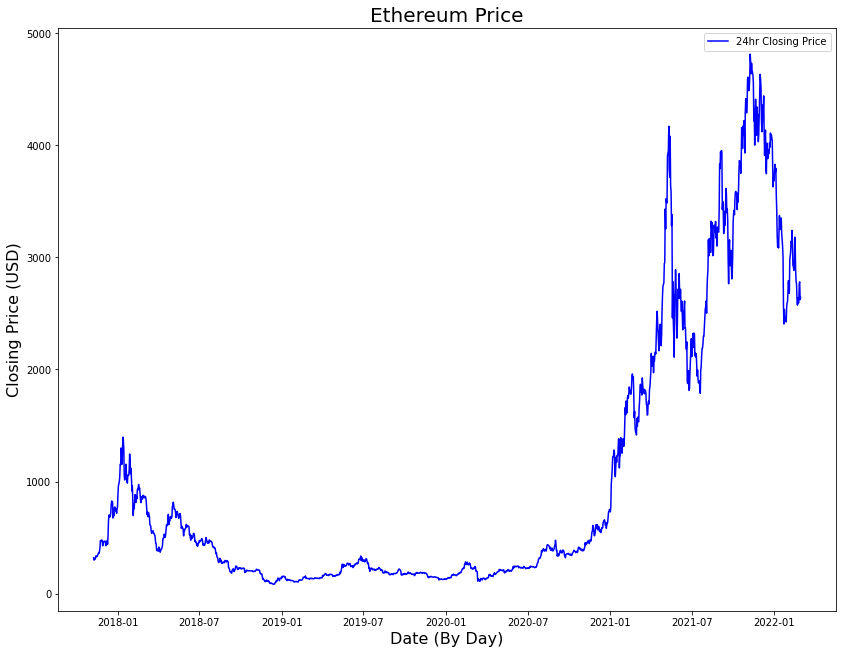

In [6]:
price = data['Close']

fig1 = plt.figure(figsize = (12,8))
axes1 = fig1.add_axes([0.1,0.1,0.9,0.9])
axes1.set_xlabel('Date (By Day)', fontsize = 16)
axes1.set_ylabel('Closing Price (USD)', fontsize=16)
axes1.set_title('Ethereum Price', fontsize=20)
axes1.plot(data['Date'], price, color = 'blue', label = '24hr Closing Price')
axes1.legend(loc=0)

We see here, the price of ethereum in a fiat currency (the USD). We recognize that this price chart is **time series** data, thus we will treat it accordingly.

Maybe we can get some descriptive statistics out of this.

In [7]:
describe_data = data[['Close', 'Open', 'High', 'Low']].describe()

describe_data

,Close,Open,High,Low
count,1573.000000,1573.000000,1573.000000,1573.000000
mean,999.626714,998.408955,1032.885389,959.114820
std,1220.645457,1220.645570,1260.146266,1174.350298
min,84.308296,84.279694,85.342743,82.829887
25%,194.493530,194.556030,199.344971,188.012695
50%,382.632629,381.971466,391.873260,369.816010
75%,1391.609375,1382.684448,1432.880005,1300.472168
max,4812.087402,4810.071289,4891.704590,4718.039063


We will plot the price chart with a rolling mean and rolling standard deviation. Let us do a rolling mean on the closing price of ETH, with a lag of about a week (so timestep of 7).

In [8]:
df1 = data.copy()

df1 = df1.set_index('Date')

df1 = df1[['Close']]

roll_mean = df1.rolling(7).mean()

roll_std = df1.rolling(7).std()

In [9]:
roll_mean

,Close
Date,
2017-11-09,NaN
2017-11-10,NaN
2017-11-11,NaN
2017-11-12,NaN
2017-11-13,NaN
...,...
2022-02-24,2654.231341
2022-02-25,2651.203927
2022-02-26,2653.691162


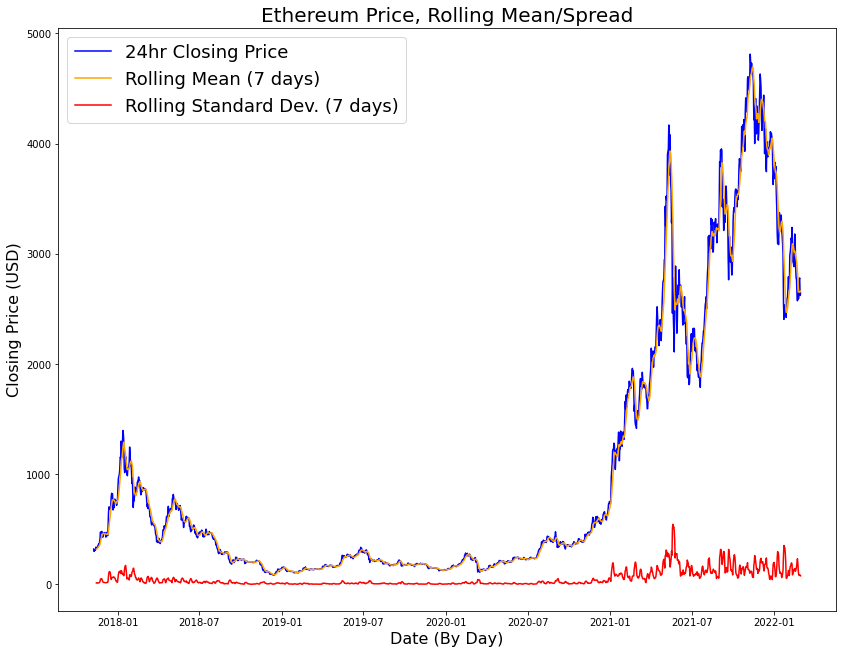

In [10]:
price = data['Close']

fig2 = plt.figure(figsize = (12,8))
axes2 = fig2.add_axes([0.1,0.1,0.9,0.9])
axes2.set_xlabel('Date (By Day)', fontsize = 16)
axes2.set_ylabel('Closing Price (USD)', fontsize=16)
axes2.set_title('Ethereum Price, Rolling Mean/Spread', fontsize=20)
axes2.plot(data['Date'], price, color = 'blue', label = '24hr Closing Price')
axes2.plot(roll_mean, color = 'orange', label='Rolling Mean (7 days)')
axes2.plot(roll_std, color = 'red', label='Rolling Standard Dev. (7 days)')
axes2.legend(loc=0, fontsize = 18)

We see here some information (although maybe not very useful) about our price chart over the years.

- The mean closing price everyday over 5 years is $999.63

- The standard deviation of the closing prices is greater than the mean!!!

- We notice how sharply the 50th percentile deviates from the mean (indicating a skew distribution of course).

For further information about our price chart as a time series, we should perform some sort of analysis on this.

### Stationarity

We will use the **Dickey-Fuller Test** on the (closing) price chart to test if we can reject the null hypothesis that this time series is stationary.

In [11]:
from statsmodels.tsa.stattools import adfuller

adft = adfuller(df1, autolag='AIC')

In [12]:
dickeyfuller_df = pd.DataFrame({'Metric': ['Test Statistics', 'p-value', 'No. of lags used', 'Number of Observations used', 'critical value (1%)', 'critical value (5%)', 'critical value (10%)'], 'Values': [adft[0], adft[1], adft[2], adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]})

dickeyfuller_df

,Metric,Values
0,Test Statistics,-0.761776
1,p-value,0.830093
2,No. of lags used,17.000000
3,Number of Observations used,1555.000000
4,critical value (1%),-3.434562
5,critical value (5%),-2.863400
6,critical value (10%),-2.567760


Since our p-value > 5% (using a 95% confidence), we can **reject our null hypothesis** that our data is stationary. In fact, our data is extremely not stationary.

We can also check for stationarity with the **KPSS** test.


In [13]:
from statsmodels.tsa.stattools import kpss
kpss_data = kpss(df1, regression='c', nlags='auto')

kpss_data

C:\Users\Chang\Desktop\Random Python Scripts\blank_env\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(3.533749080071481,
 0.01,
 25,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Thus, we see that the p value is significantly less than 0.05 (in fact, it's so small that the test returned a warning), therefore, we accept the null hypothesis that our time series is not stationary.

Although the KPSS and Dickey-Fuller are not guaranteed to be conclusive, in this case, within statistical uncertainty, we can be confident that our series is not stationary.

### Autocorrelation

We will choose to compute various autocorrelations for various timesteps. Times we will choose are 1 day, 4 days (about half a week), 7 days (a week), 14 days (2 weeks), 30 days (about a month), and 180 days (about half a year). We will see to what extent the prices of Ethereum depend on the previous timesteps.

In [14]:
li_timesteps = [1, 4, 7, 14, 30, 90, 180, 360]

# loop through timesteps to see autocorrelations for various timesteps
li_autocorrs = []
for t in li_timesteps:
    autocorr = df1['Close'].autocorr(lag=t)
    li_autocorrs.append(autocorr)
    print(f'Lag of {t} days has autocorrelation {autocorr}.')
    


Lag of 1 days has autocorrelation 0.9979240092526213.
Lag of 4 days has autocorrelation 0.9923982777691294.
Lag of 7 days has autocorrelation 0.986348450869336.
Lag of 14 days has autocorrelation 0.9725983613669439.
Lag of 30 days has autocorrelation 0.9464097572768488.
Lag of 90 days has autocorrelation 0.8725672374947042.
Lag of 180 days has autocorrelation 0.8134351218094571.
Lag of 360 days has autocorrelation 0.25176115855162723.


We can see how autocorrelation trends over differences in time.

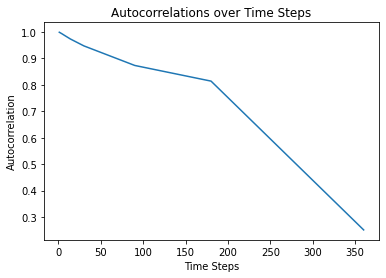

In [15]:
plt.plot(li_timesteps, li_autocorrs)
plt.title('Autocorrelations over Time Steps')
plt.ylabel('Autocorrelation')
plt.xlabel('Time Steps')
plt.show()

Thus, we see that the correlation with neighboring timesteps of data falls as we look further and further away from the current time step. This is an indication of volatility and unpredictability of the cryptocurrency market and it has important consequences on our attempts to forecast the price of Ethereum; the similarity in data between time steps gets lesser and lesser as time goes on. Therefore, our predictions on crypto will get less and less reliable as we look further into the future. 

The computations above seem to suggest that Ethereum, specifically, has high correlation between prices within 1 month of each other. This, naively, indicates that making predictions on Ethereum prices outside of the window of a month will likely be a non-trivial task.

### Trend Decomposition

We will break the price chart up into residuals, seasonality, trends.

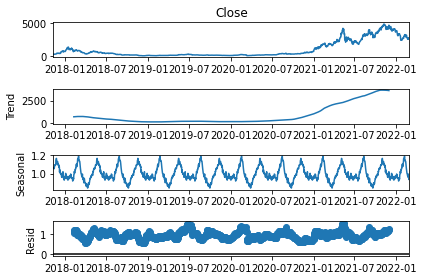

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df1['Close'], model = 'multiplicative', period = 180)

decomp.plot()
plt.show()

### Preliminary Forecasting

We will attempt to forecast this data with traditional means before we move onto using our LSTM to predict crypto prices.

Since our KPSS and Dickey-Fuller indicate that our price chart is non-stationary through hypothesis testing (meaning due to unit root causes), so as long as we can do some differencing. Therefore, we can use the ARIMA model to forecast this series.

In [17]:
# train test split for the ARIMA
# we will do about a 75-25 train-test split

df1['Date'] = df1.index

train = df1.loc[df1['Date'] < pd.to_datetime('2021-01-27', format = '%Y-%m-%d')]

train['train'] = train['Close']

train = train[['train']]

test = df1.loc[df1['Date'] >= pd.to_datetime('2021-01-27', format = '%Y-%m-%d')]

test['test'] = test['Close']

test = test[['test']]

print(train.shape)
print(test.shape)

(1175, 1)
(398, 1)


C:\Users\Chang\AppData\Local\Temp\ipykernel_47608\2774646654.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['train'] = train['Close']
C:\Users\Chang\AppData\Local\Temp\ipykernel_47608\2774646654.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['test'] = test['Close']


In [18]:
train.head()

,train
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003


In [19]:
test.head()

,test
Date,
2021-01-27,1253.187134
2021-01-28,1332.492188
2021-01-29,1382.522827
2021-01-30,1376.115479
2021-01-31,1314.986206


Visualizing our train-test split...

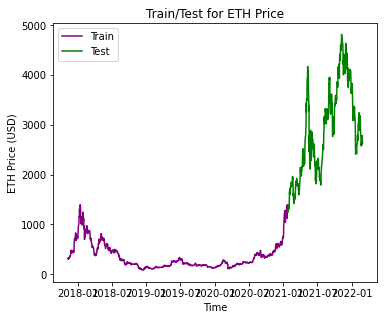

In [20]:
fig_3 = plt.figure(figsize = (12,8))  #make a figure objects
axes_3 = fig_3.add_axes([0.1, 0.1, 0.9, 0.9])  
axes_3.set_xlabel('Time')
axes_3.set_ylabel('ETH Price (USD)')
axes_3.set_title('Train/Test for ETH Price')
axes_3.plot(train, color = 'purple', label = 'Train')
axes_3.plot(test, color = 'green', label = 'Test')
axes_3.legend(loc = 0)

Now import our ARIMA model and forecast

In [21]:
from pmdarima.arima import auto_arima

In [22]:
model = auto_arima(train, trace=True,
                  error_action='ignore',
                  suppress_warnings=True)
# fit the model
model.fit(train)

# inference the model
forecast = model.predict(n_periods = len(test))

forecast = pd.DataFrame(forecast,
                       index = test.index,
                       columns = ['Price Prediction'])


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11127.324, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11153.599, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11154.781, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11154.771, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11152.771, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11158.283, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11158.684, Time=0.69 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11126.277, Time=1.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11160.564, Time=0.54 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=11125.893, Time=1.68 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11162.414, Time=0.37 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=11122.018, Time=1.90 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=11160.487, Time=0.73 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=11127.905, Time=2.08 sec
 ARIMA(4,1,3)(0,0,0

In [23]:
forecast

,Price Prediction
Date,
2021-01-27,1324.474654
2021-01-28,1337.569575
2021-01-29,1388.944586
2021-01-30,1387.985166
2021-01-31,1350.592287
...,...
2022-02-24,1361.370688
2022-02-25,1361.370688
2022-02-26,1361.370688


Now to compare the price predictions from the ARIMA model to the training and testing data...

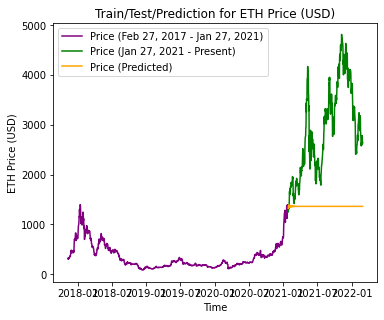

In [24]:
fig_4 = plt.figure(figsize = (12,8))  #make a figure objects
axes_4 = fig_4.add_axes([0.1, 0.1, 0.9, 0.9])  
axes_4.set_xlabel('Time')
axes_4.set_ylabel('ETH Price (USD)')
axes_4.set_title('Train/Test/Prediction for ETH Price (USD)')
axes_4.plot(train, color = 'purple', label = 'Price (Feb 27, 2017 - Jan 27, 2021)')
axes_4.plot(test, color = 'green', label = 'Price (Jan 27, 2021 - Present)')
axes_4.plot(forecast, color = 'orange', label='Price (Predicted)')
axes_4.legend(loc = 0)


This result is where we clearly see the issue with using traditional time series forecasting methods with cryptocurrencies. 

Recall how we mentioned that cryptocurrencies were **extremely** volatile, and that was reflected in the autocorrelations between various lagging windows. In particular, we note the drastic decrease in the autocorrelation between anything after a 1-2 month window. This implied that the price data would be extremely unpredictable outside of a short window, and that is precisely what is reflected here!

Notice that our training data (prices from Feb 27, 2017 - Jan 27, 2021) all had a maximum around where the numerical scale of the predictions lie. We can attribute this to the drastic drop-off of autocorrelation outside of a relatively short window of time. This is why any forecasting must take into account both the general trend and local behavior. This is where we desire an LSTM RNN.

# Part 2: Crypto and LSTM's

As mentioned before, an LSTM is a type of Recurrent Neural Network that takes in sequential data and, speaking in layman's terms, has a "memory" about sequential data.

## Preprocessing Data for LSTM

In [74]:
# create a copy of the data with only the closing price

df2 = data.copy()

In [75]:
df2

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...,...
1568,2022-02-24,2588.166260,2689.047607,2308.914795,2598.067139,2598.067139,29312342666
1569,2022-02-25,2598.436279,2821.972412,2579.208008,2764.535645,2764.535645,17208902048
1570,2022-02-26,2764.989502,2849.424072,2745.009033,2781.111816,2781.111816,11724648351
1571,2022-02-27,2780.504395,2831.125488,2581.615723,2621.801758,2621.801758,16150857254


In [76]:
df2['Date'] = pd.to_datetime(df2['Date'], format = '%Y-%m-%d')

df2 = df2.set_index('Date')

df2 = df2[['Close']]

df2

,Close
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003
...,...
2022-02-24,2598.067139
2022-02-25,2764.535645
2022-02-26,2781.111816


In [77]:
from sklearn.preprocessing import MinMaxScaler

# scale to values between 0 - 1.0
min_max_scaler = MinMaxScaler()

scaled_data = min_max_scaler.fit_transform(df2)

scaled_data.shape

(1573, 1)

In [78]:
np.min(scaled_data), np.max(scaled_data)

(0.0, 1.0)

## Train Test Split

**Note: Here, we cannot use the sklearn train test split because we are using a time series, and the order of our data points is extremely important. We must train test split sequentially.**

The way we are splitting the data is the following:

We are specifying a window for which we will collect training data, and every window is staggered by one day. We will be predicting the price on the one day that falls right outside of our window. So for example, if our training set is something like:

- 12-21-2021
- 12-22-2021
- 12-23-2021
- 12-24-2021
- 12-25-2021

Then our test for this batch will be:

- 12-26-2021

Then our next training window will consist of:

- 12-22-2021
- 12-23-2021
- 12-24-2021
- 12-25-2021
- 12-26-2021

And our test for this training batch will be:

- 12-27-2021

and so on and so forth...

Now let us split the data accordingly.

In [79]:
def train_test_sequential(data, start, end, past_window, future_window):
    li_data = []
    li_label = []
    
    start += past_window
    if end is None:
        end = len(data) - future_window
        
    for i in range(start, end):
        ind = range(i - past_window, i)
        li_data.append(np.reshape(data[ind], (past_window, 1)))
        li_label.append(data[i+future_window])
    return np.array(li_data), np.array(li_label)

In [80]:
past_window = 5
future_window = 0

train_ratio = int(len(scaled_data) * 0.75)

x_train, y_train = train_test_sequential(scaled_data,
                                        0,
                                        train_ratio,
                                        past_window,
                                        future_window)

x_test, y_test = train_test_sequential(scaled_data,
                                      train_ratio,
                                      None,
                                      past_window,
                                      future_window)



## Our LSTM Model

**Note: We should play around with this.**

In [81]:
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [82]:
neurons = 64
lr = 0.0001
activation = 'linear'
adam = Adam(learning_rate = lr)
loss = 'mse'
batch_size = 5
epochs = 250

In [83]:
model = keras.Sequential(name = 'ETH_LSTM1')

# create layers
model.add(layers.LSTM(units = neurons, activation = activation, input_shape = (None, 1)))
model.add(layers.LeakyReLU(alpha = 0.5))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1))

# compile the model
model.compile(optimizer = adam, loss = loss)

In [84]:
model.summary()

Model: "ETH_LSTM1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64)                0         
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [85]:
history_1 = model.fit(x_train, y_train,
                     validation_split = 0.2,
                     batch_size = batch_size,
                     epochs = epochs,
                     shuffle=False)

Epoch 1/250
188/188 [==============================] - 4s 9ms/step - loss: 0.0039 - val_loss: 0.0070
Epoch 2/250
188/188 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 0.0054
Epoch 3/250
188/188 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 4/250
188/188 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0037
Epoch 5/250
188/188 [==============================] - 1s 4ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 6/250
188/188 [==============================] - 1s 3ms/step - loss: 9.2668e-04 - val_loss: 0.0022
Epoch 7/250
188/188 [==============================] - 1s 4ms/step - loss: 6.2668e-04 - val_loss: 0.0015
Epoch 8/250
188/188 [==============================] - 1s 7ms/step - loss: 3.9199e-04 - val_loss: 9.9816e-04
Epoch 9/250
188/188 [==============================] - 1s 4ms/step - loss: 2.5931e-04 - val_loss: 6.5544e-04
Epoch 10/250
188/188 [==============================] - 1s 6ms/step

Epoch 76/250
188/188 [==============================] - 1s 3ms/step - loss: 1.0229e-04 - val_loss: 3.4594e-04
Epoch 77/250
188/188 [==============================] - 1s 3ms/step - loss: 1.0849e-04 - val_loss: 3.4029e-04
Epoch 78/250
188/188 [==============================] - 1s 3ms/step - loss: 1.0034e-04 - val_loss: 3.3215e-04
Epoch 79/250
188/188 [==============================] - 1s 3ms/step - loss: 1.0130e-04 - val_loss: 3.3439e-04
Epoch 80/250
188/188 [==============================] - 1s 3ms/step - loss: 9.9416e-05 - val_loss: 3.4158e-04
Epoch 81/250
188/188 [==============================] - 1s 3ms/step - loss: 9.6882e-05 - val_loss: 3.3969e-04
Epoch 82/250
188/188 [==============================] - 1s 3ms/step - loss: 9.9323e-05 - val_loss: 3.4085e-04
Epoch 83/250
188/188 [==============================] - 1s 3ms/step - loss: 1.0315e-04 - val_loss: 3.3607e-04
Epoch 84/250
188/188 [==============================] - 1s 3ms/step - loss: 1.0307e-04 - val_loss: 3.3604e-04
Epoch 85/2

188/188 [==============================] - 1s 5ms/step - loss: 7.4068e-05 - val_loss: 2.4987e-04
Epoch 151/250
188/188 [==============================] - 1s 4ms/step - loss: 7.3015e-05 - val_loss: 2.5300e-04
Epoch 152/250
188/188 [==============================] - 1s 3ms/step - loss: 7.2067e-05 - val_loss: 2.4519e-04
Epoch 153/250
188/188 [==============================] - 1s 3ms/step - loss: 8.1937e-05 - val_loss: 2.4752e-04
Epoch 154/250
188/188 [==============================] - 1s 3ms/step - loss: 7.3244e-05 - val_loss: 2.3518e-04
Epoch 155/250
188/188 [==============================] - 1s 3ms/step - loss: 7.6322e-05 - val_loss: 2.3234e-04
Epoch 156/250
188/188 [==============================] - 1s 4ms/step - loss: 7.0366e-05 - val_loss: 2.3083e-04
Epoch 157/250
188/188 [==============================] - 1s 3ms/step - loss: 7.7049e-05 - val_loss: 2.3784e-04
Epoch 158/250
188/188 [==============================] - 1s 3ms/step - loss: 7.1969e-05 - val_loss: 2.3516e-04
Epoch 159/250
1

Epoch 224/250
188/188 [==============================] - 1s 3ms/step - loss: 6.1605e-05 - val_loss: 1.9756e-04
Epoch 225/250
188/188 [==============================] - 1s 3ms/step - loss: 6.0120e-05 - val_loss: 1.9148e-04
Epoch 226/250
188/188 [==============================] - 1s 3ms/step - loss: 5.4657e-05 - val_loss: 1.7122e-04
Epoch 227/250
188/188 [==============================] - 1s 4ms/step - loss: 5.4718e-05 - val_loss: 1.8968e-04
Epoch 228/250
188/188 [==============================] - 1s 3ms/step - loss: 5.6067e-05 - val_loss: 1.7748e-04
Epoch 229/250
188/188 [==============================] - 1s 3ms/step - loss: 5.7376e-05 - val_loss: 1.8252e-04
Epoch 230/250
188/188 [==============================] - 0s 3ms/step - loss: 5.3019e-05 - val_loss: 1.8355e-04
Epoch 231/250
188/188 [==============================] - 1s 3ms/step - loss: 5.5347e-05 - val_loss: 1.8451e-04
Epoch 232/250
188/188 [==============================] - 1s 3ms/step - loss: 5.8629e-05 - val_loss: 1.7465e-04
E

In [86]:
history_1.history.keys()

dict_keys(['loss', 'val_loss'])

### Plot our model's performance over epochs

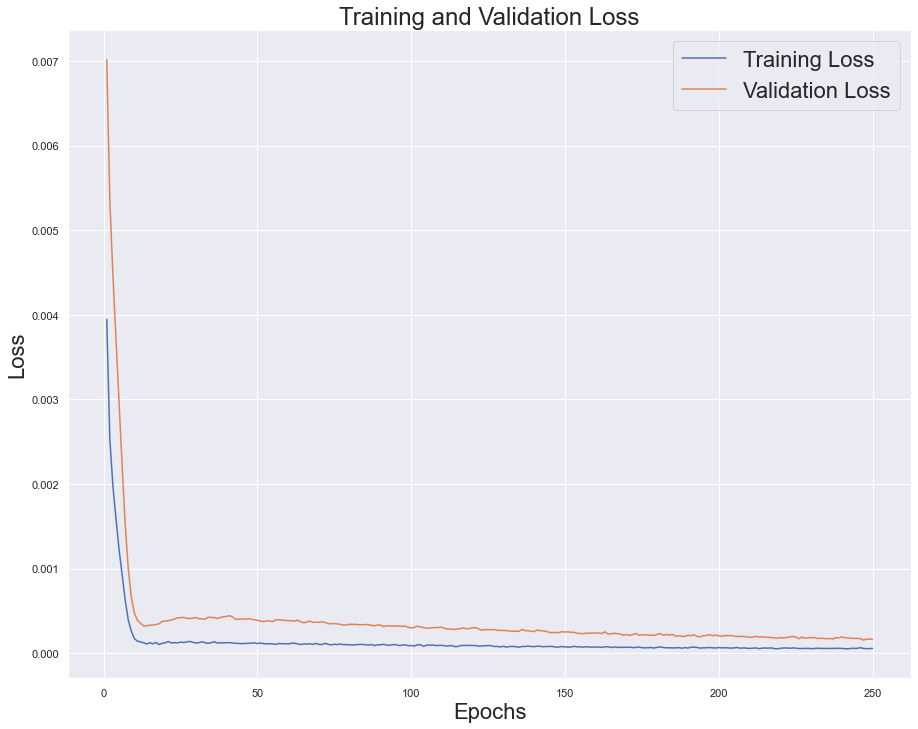

In [87]:
epoch_range = range(1, epochs+1)
val_loss = history_1.history['val_loss']
train_loss = history_1.history['loss']

fig_perf = plt.figure(figsize = (12,8))
axis_perf = fig_perf.add_axes([0.1,0.1,0.9,0.9])

axis_perf.set_ylabel('Loss', fontsize=22)
axis_perf.set_xlabel('Epochs', fontsize=22)
axis_perf.set_title('Training and Validation Loss', fontsize=24)
axis_perf.plot(epoch_range, train_loss, label = 'Training Loss')
axis_perf.plot(epoch_range, val_loss, label='Validation Loss')
axis_perf.legend(loc=0, fontsize=22)

### Predict Using our LSTM

In [173]:
from sklearn.metrics import r2_score

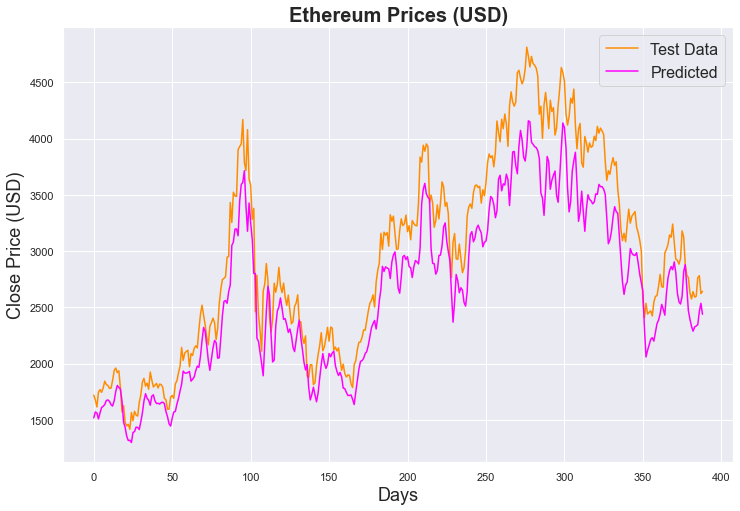

In [93]:
original_price = pd.DataFrame(min_max_scaler.inverse_transform(y_test), columns = ['Close Price'])

# get the predicted prices
predictions_1 = model.predict(x_test)
eth_predictions_1 = min_max_scaler.inverse_transform(predictions_1)
predictions_df = pd.DataFrame(eth_predictions_1, columns = ['Predicted Close Price'])

# plot on seaborn
plt.figure(figsize=(12,8))
sns.set_theme(style='darkgrid')
eth_axis = sns.lineplot(x=original_price.index, y=original_price['Close Price'], label='Test Data', color='darkorange')
eth_axis = sns.lineplot(x=predictions_df.index, y=predictions_df['Predicted Close Price'], label='Predicted', color='fuchsia')
eth_axis.set_title('Ethereum Prices (USD)', fontsize=20, fontweight='bold')
eth_axis.set_xlabel('Days', fontsize=18)
eth_axis.set_ylabel('Close Price (USD)', fontsize=18)
eth_axis.legend(loc=0, fontsize=16)

In [92]:
predictions_df

,Predicted Close Price
0,1517.296143
1,1569.786621
2,1561.083008
3,1507.790161
4,1562.148193
...,...
384,2333.466553
385,2345.917236
386,2463.506348
387,2535.850830


In [91]:
original_price

,Close Price
0,1718.650879
1,1677.846802
2,1614.227783
3,1746.616821
4,1768.035034
...,...
384,2598.067139
385,2764.535645
386,2781.111816
387,2621.801758


In [176]:
model_1_score = r2_score(original_price['Close Price'], eth_predictions_1)
print(f'We have an R2 Score of {model_1_score} for Model 1.')

We have an R2 Score of 0.798695342437679 for Model 1.


### Prediction 2

Let us change the number of units in the LSTM.

In [143]:
neurons1_LSTM2 = 20
neurons2_LSTM2 = 40
lr = 0.0001
activation = 'linear'
adam = Adam(learning_rate = lr)
loss = 'mse'
batch_size = 5
epochs = 250

In [144]:
model2 = keras.Sequential(name = 'ETH_LSTM2')

# create layers
model2.add(layers.LSTM(units = 256, activation = activation, input_shape = (None, 1)))
model2.add(layers.LeakyReLU(alpha = 0.5))
model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(1))

# compile the model
model2.compile(optimizer = adam, loss = loss)


In [145]:
model2.summary()

Model: "ETH_LSTM2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 256)               264192    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 256)               0         
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [146]:
history_2 = model2.fit(x_train, y_train,
                     validation_split = 0.2,
                     batch_size = batch_size,
                     epochs = epochs,
                     shuffle=False)

Epoch 1/250
188/188 [==============================] - 2s 8ms/step - loss: 0.0032 - val_loss: 0.0055
Epoch 2/250
188/188 [==============================] - 1s 6ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 3/250
188/188 [==============================] - 1s 6ms/step - loss: 7.9698e-04 - val_loss: 0.0023
Epoch 4/250
188/188 [==============================] - 1s 6ms/step - loss: 4.7976e-04 - val_loss: 0.0015
Epoch 5/250
188/188 [==============================] - 1s 6ms/step - loss: 3.0857e-04 - val_loss: 0.0011
Epoch 6/250
188/188 [==============================] - 1s 7ms/step - loss: 2.1553e-04 - val_loss: 8.2171e-04
Epoch 7/250
188/188 [==============================] - 1s 6ms/step - loss: 1.8223e-04 - val_loss: 7.1590e-04
Epoch 8/250
188/188 [==============================] - 1s 6ms/step - loss: 1.6341e-04 - val_loss: 6.8486e-04
Epoch 9/250
188/188 [==============================] - 1s 6ms/step - loss: 1.5781e-04 - val_loss: 6.7422e-04
Epoch 10/250
188/188 [=========================

Epoch 76/250
188/188 [==============================] - 1s 7ms/step - loss: 9.1676e-05 - val_loss: 4.1498e-04
Epoch 77/250
188/188 [==============================] - 1s 7ms/step - loss: 1.0152e-04 - val_loss: 4.3424e-04
Epoch 78/250
188/188 [==============================] - 1s 7ms/step - loss: 1.0284e-04 - val_loss: 4.1745e-04
Epoch 79/250
188/188 [==============================] - 1s 7ms/step - loss: 1.0425e-04 - val_loss: 4.1806e-04
Epoch 80/250
188/188 [==============================] - 1s 7ms/step - loss: 9.9533e-05 - val_loss: 4.0977e-04
Epoch 81/250
188/188 [==============================] - 1s 7ms/step - loss: 8.8217e-05 - val_loss: 4.2075e-04
Epoch 82/250
188/188 [==============================] - 1s 7ms/step - loss: 9.5219e-05 - val_loss: 4.2124e-04
Epoch 83/250
188/188 [==============================] - 1s 7ms/step - loss: 9.7264e-05 - val_loss: 4.0371e-04
Epoch 84/250
188/188 [==============================] - 1s 7ms/step - loss: 9.3055e-05 - val_loss: 3.9954e-04
Epoch 85/2

188/188 [==============================] - 1s 7ms/step - loss: 6.1232e-05 - val_loss: 2.0681e-04
Epoch 151/250
188/188 [==============================] - 1s 7ms/step - loss: 5.9693e-05 - val_loss: 2.0352e-04
Epoch 152/250
188/188 [==============================] - 1s 7ms/step - loss: 5.8011e-05 - val_loss: 1.9434e-04
Epoch 153/250
188/188 [==============================] - 1s 7ms/step - loss: 5.4412e-05 - val_loss: 1.8872e-04
Epoch 154/250
188/188 [==============================] - 1s 7ms/step - loss: 5.7137e-05 - val_loss: 2.2377e-04
Epoch 155/250
188/188 [==============================] - 1s 8ms/step - loss: 5.7455e-05 - val_loss: 1.9239e-04
Epoch 156/250
188/188 [==============================] - 1s 7ms/step - loss: 5.4525e-05 - val_loss: 2.1143e-04
Epoch 157/250
188/188 [==============================] - 1s 7ms/step - loss: 5.9681e-05 - val_loss: 1.9130e-04
Epoch 158/250
188/188 [==============================] - 1s 7ms/step - loss: 5.4837e-05 - val_loss: 2.0643e-04
Epoch 159/250
1

Epoch 224/250
188/188 [==============================] - 1s 8ms/step - loss: 4.5459e-05 - val_loss: 1.3645e-04
Epoch 225/250
188/188 [==============================] - 1s 8ms/step - loss: 4.3160e-05 - val_loss: 1.4451e-04
Epoch 226/250
188/188 [==============================] - 1s 8ms/step - loss: 4.4983e-05 - val_loss: 1.4334e-04
Epoch 227/250
188/188 [==============================] - 1s 7ms/step - loss: 4.2349e-05 - val_loss: 1.3413e-04
Epoch 228/250
188/188 [==============================] - 1s 7ms/step - loss: 4.1816e-05 - val_loss: 1.5340e-04
Epoch 229/250
188/188 [==============================] - 1s 7ms/step - loss: 4.7143e-05 - val_loss: 1.5248e-04
Epoch 230/250
188/188 [==============================] - 1s 8ms/step - loss: 4.3969e-05 - val_loss: 1.5491e-04
Epoch 231/250
188/188 [==============================] - 2s 9ms/step - loss: 4.0984e-05 - val_loss: 1.5435e-04
Epoch 232/250
188/188 [==============================] - 2s 9ms/step - loss: 4.3022e-05 - val_loss: 1.4412e-04
E

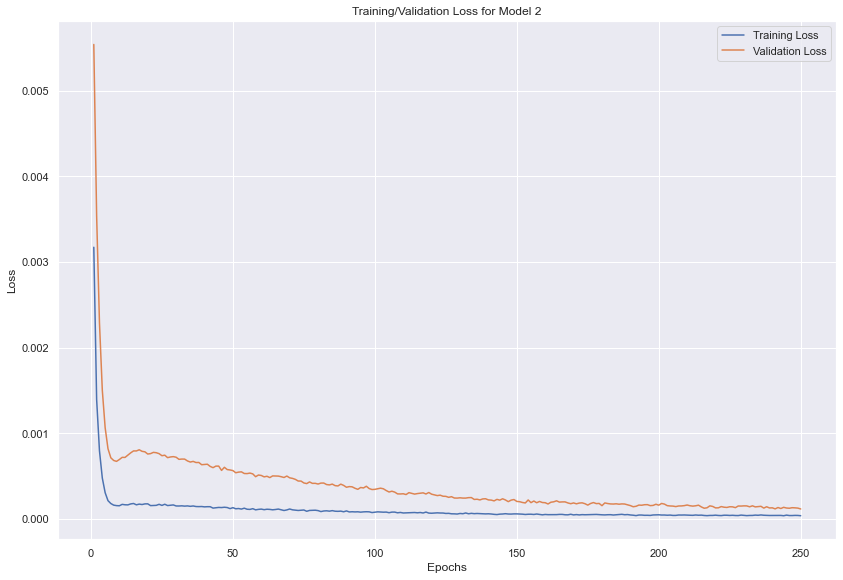

In [147]:
train_loss2, val_loss2 = history_2.history['loss'], history_2.history['val_loss']
epoch_range = range(1,epochs+1)

fig_perf2 = plt.figure(figsize = (12,8))
axis_perf2 = fig_perf2.add_axes([0.1,0.1,0.9,0.9])

axis_perf2.set_ylabel('Loss')
axis_perf2.set_xlabel('Epochs')
axis_perf2.set_title('Training/Validation Loss for Model 2')
axis_perf2.plot(epoch_range, train_loss2, label='Training Loss')
axis_perf2.plot(epoch_range, val_loss2, label='Validation Loss')
axis_perf2.legend(loc=0)

In [148]:
# prediction for model 2

predictions_2 = model2.predict(x_test)
eth_predictions_2 = min_max_scaler.inverse_transform(predictions_2)
predictions2_df = pd.DataFrame(eth_predictions_2, columns = ['Predicted Close Price'])

predictions2_df

,Predicted Close Price
0,1510.691772
1,1581.662598
2,1575.608032
3,1500.943359
4,1603.156616
...,...
384,2407.420166
385,2395.366699
386,2549.656250
387,2596.416016


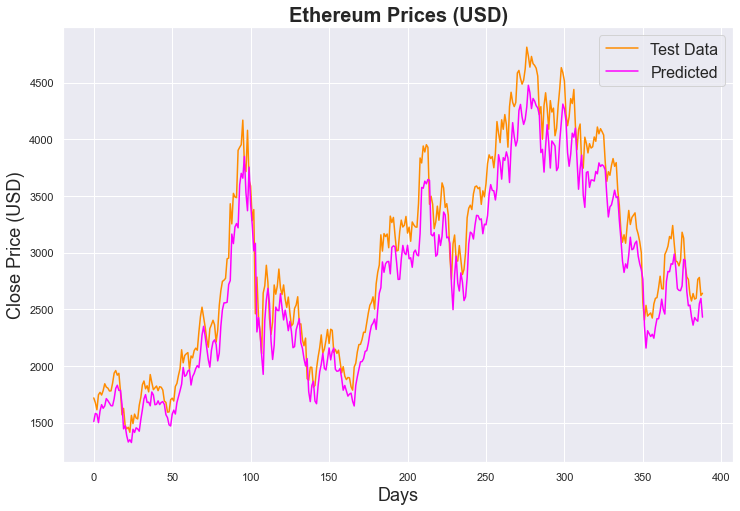

In [149]:
# plot on seaborn
plt.figure(figsize=(12,8))
sns.set_theme(style='darkgrid')
eth_axis2 = sns.lineplot(x=original_price.index, y=original_price['Close Price'], label='Test Data', color='darkorange')
eth_axis2 = sns.lineplot(x=predictions2_df.index, y=predictions2_df['Predicted Close Price'], label='Predicted', color='fuchsia')
eth_axis2.set_title('Ethereum Prices (USD)', fontsize=20, fontweight='bold')
eth_axis2.set_xlabel('Days', fontsize=18)
eth_axis2.set_ylabel('Close Price (USD)', fontsize=18)
eth_axis2.legend(loc=0, fontsize=16)

In [179]:
model_2_score = r2_score(original_price['Close Price'], eth_predictions_2)
print(f'We have an R2 Score of {model_2_score} for Model 2.')

We have an R2 Score of 0.9009391113089549 for Model 2.


### Prediction 3

In [160]:
neurons1_LSTM2 = 20
neurons2_LSTM2 = 40
lr = 0.0001
adam = Adam(learning_rate = lr)
loss = 'mse'
batch_size = 5
epochs = 250

In [161]:
model3 = keras.Sequential(name = 'ETH_LSTM3')

# create layers
model3.add(layers.LSTM(units = 50, return_sequences=True, input_shape = (5, 1)))
model3.add(layers.LSTM(units = 100))
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(1, activation='linear'))

# compile the model
model3.compile(optimizer = adam, loss = loss)

model3.summary()

Model: "ETH_LSTM3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 5, 50)             10400     
                                                                 
 lstm_36 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [162]:
history_3 = model3.fit(x_train, y_train,
                     validation_split = 0.2,
                     batch_size = batch_size,
                     epochs = epochs,
                     shuffle=False)

Epoch 1/250
188/188 [==============================] - 4s 7ms/step - loss: 0.0033 - val_loss: 0.0067
Epoch 2/250
188/188 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 0.0054
Epoch 3/250
188/188 [==============================] - 1s 4ms/step - loss: 0.0015 - val_loss: 0.0041
Epoch 4/250
188/188 [==============================] - 1s 4ms/step - loss: 9.7376e-04 - val_loss: 0.0029
Epoch 5/250
188/188 [==============================] - 1s 4ms/step - loss: 6.4159e-04 - val_loss: 0.0019
Epoch 6/250
188/188 [==============================] - 1s 4ms/step - loss: 3.8529e-04 - val_loss: 0.0013
Epoch 7/250
188/188 [==============================] - 1s 4ms/step - loss: 2.7511e-04 - val_loss: 9.4697e-04
Epoch 8/250
188/188 [==============================] - 1s 4ms/step - loss: 1.9099e-04 - val_loss: 7.5874e-04
Epoch 9/250
188/188 [==============================] - 1s 4ms/step - loss: 1.8358e-04 - val_loss: 6.3619e-04
Epoch 10/250
188/188 [==============================] -

Epoch 76/250
188/188 [==============================] - 1s 5ms/step - loss: 1.0672e-04 - val_loss: 4.3138e-04
Epoch 77/250
188/188 [==============================] - 1s 5ms/step - loss: 1.0395e-04 - val_loss: 4.6571e-04
Epoch 78/250
188/188 [==============================] - 1s 5ms/step - loss: 1.1185e-04 - val_loss: 4.7054e-04
Epoch 79/250
188/188 [==============================] - 1s 5ms/step - loss: 1.1735e-04 - val_loss: 4.2978e-04
Epoch 80/250
188/188 [==============================] - 1s 5ms/step - loss: 1.0799e-04 - val_loss: 4.2331e-04
Epoch 81/250
188/188 [==============================] - 1s 5ms/step - loss: 1.0895e-04 - val_loss: 4.1449e-04
Epoch 82/250
188/188 [==============================] - 1s 5ms/step - loss: 1.0778e-04 - val_loss: 4.1034e-04
Epoch 83/250
188/188 [==============================] - 1s 5ms/step - loss: 1.0314e-04 - val_loss: 4.2095e-04
Epoch 84/250
188/188 [==============================] - 1s 5ms/step - loss: 1.0860e-04 - val_loss: 4.3043e-04
Epoch 85/2

188/188 [==============================] - 1s 5ms/step - loss: 7.8638e-05 - val_loss: 2.5860e-04
Epoch 151/250
188/188 [==============================] - 1s 5ms/step - loss: 6.2646e-05 - val_loss: 2.4722e-04
Epoch 152/250
188/188 [==============================] - 1s 5ms/step - loss: 6.1631e-05 - val_loss: 2.3235e-04
Epoch 153/250
188/188 [==============================] - 1s 5ms/step - loss: 6.8272e-05 - val_loss: 2.2637e-04
Epoch 154/250
188/188 [==============================] - 1s 5ms/step - loss: 6.1074e-05 - val_loss: 2.4356e-04
Epoch 155/250
188/188 [==============================] - 1s 5ms/step - loss: 6.7227e-05 - val_loss: 2.5522e-04
Epoch 156/250
188/188 [==============================] - 1s 5ms/step - loss: 6.8141e-05 - val_loss: 2.6557e-04
Epoch 157/250
188/188 [==============================] - 1s 5ms/step - loss: 6.8283e-05 - val_loss: 2.5198e-04
Epoch 158/250
188/188 [==============================] - 1s 5ms/step - loss: 6.9507e-05 - val_loss: 2.3295e-04
Epoch 159/250
1

Epoch 224/250
188/188 [==============================] - 1s 5ms/step - loss: 4.8917e-05 - val_loss: 1.6111e-04
Epoch 225/250
188/188 [==============================] - 1s 5ms/step - loss: 5.6745e-05 - val_loss: 1.6262e-04
Epoch 226/250
188/188 [==============================] - 1s 5ms/step - loss: 4.8094e-05 - val_loss: 1.4321e-04
Epoch 227/250
188/188 [==============================] - 1s 5ms/step - loss: 4.4017e-05 - val_loss: 1.4275e-04
Epoch 228/250
188/188 [==============================] - 1s 5ms/step - loss: 4.3801e-05 - val_loss: 1.3158e-04
Epoch 229/250
188/188 [==============================] - 1s 5ms/step - loss: 4.5896e-05 - val_loss: 1.4651e-04
Epoch 230/250
188/188 [==============================] - 1s 5ms/step - loss: 4.7204e-05 - val_loss: 1.3568e-04
Epoch 231/250
188/188 [==============================] - 1s 5ms/step - loss: 4.9594e-05 - val_loss: 1.5599e-04
Epoch 232/250
188/188 [==============================] - 1s 5ms/step - loss: 5.6470e-05 - val_loss: 1.5814e-04
E

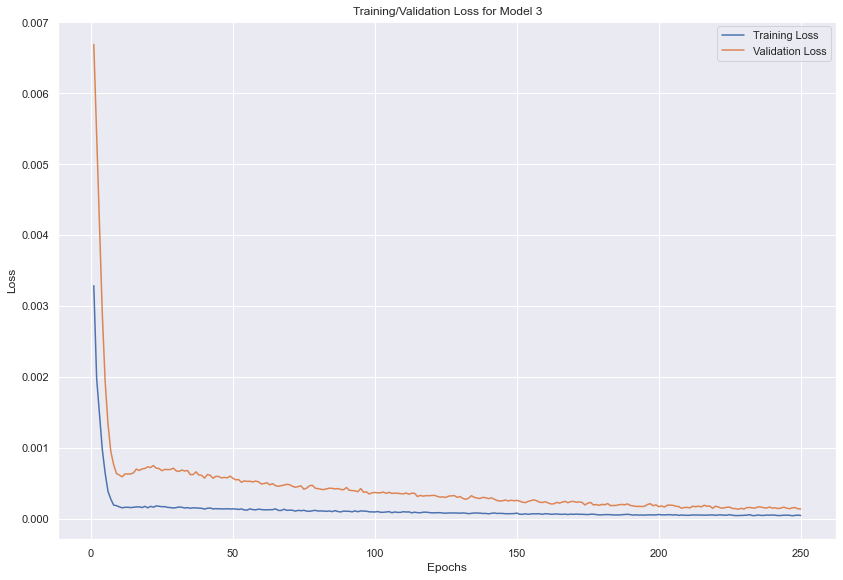

In [163]:
train_loss3, val_loss3 = history_3.history['loss'], history_3.history['val_loss']
epoch_range = range(1,epochs+1)

fig_perf3 = plt.figure(figsize = (12,8))
axis_perf3 = fig_perf3.add_axes([0.1,0.1,0.9,0.9])

axis_perf3.set_ylabel('Loss')
axis_perf3.set_xlabel('Epochs')
axis_perf3.set_title('Training/Validation Loss for Model 3')
axis_perf3.plot(epoch_range, train_loss3, label='Training Loss')
axis_perf3.plot(epoch_range, val_loss3, label='Validation Loss')
axis_perf3.legend(loc=0)

In [164]:
# prediction for model 3

predictions_3 = model3.predict(x_test)
eth_predictions_3 = min_max_scaler.inverse_transform(predictions_3)
predictions3_df = pd.DataFrame(eth_predictions_3, columns = ['Predicted Close Price'])

predictions3_df

,Predicted Close Price
0,1496.281860
1,1604.357666
2,1553.026611
3,1482.531738
4,1611.271362
...,...
384,2339.795654
385,2359.453857
386,2545.186279
387,2549.324463


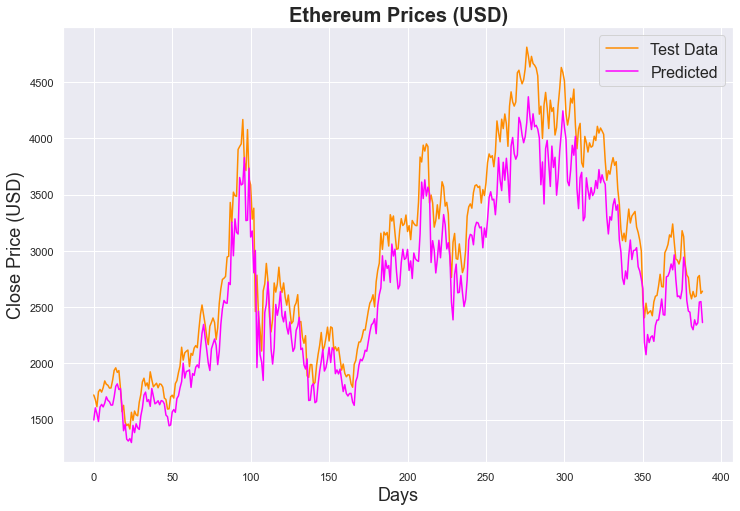

In [165]:
# plot on seaborn
plt.figure(figsize=(12,8))
sns.set_theme(style='darkgrid')
eth_axis3 = sns.lineplot(x=original_price.index, y=original_price['Close Price'], label='Test Data', color='darkorange')
eth_axis3 = sns.lineplot(x=predictions3_df.index, y=predictions3_df['Predicted Close Price'], label='Predicted', color='fuchsia')
eth_axis3.set_title('Ethereum Prices (USD)', fontsize=20, fontweight='bold')
eth_axis3.set_xlabel('Days', fontsize=18)
eth_axis3.set_ylabel('Close Price (USD)', fontsize=18)
eth_axis3.legend(loc=0, fontsize=16)

In [178]:
model_3_score = r2_score(original_price['Close Price'], eth_predictions_3)
print(f'We have an R2 Score of {model_3_score} for Model 3.')

We have an R2 Score of 0.8453279427648285 for Model 3.


### Prediction 4

In [166]:
neurons1_LSTM2 = 20
neurons2_LSTM2 = 40
lr = 0.0001
adam = Adam(learning_rate = lr)
loss = 'mse'
batch_size = 5
epochs = 250

In [168]:
model4 = keras.Sequential(name = 'ETH_LSTM4')

# create layers
model4.add(layers.LSTM(units = 50, return_sequences=True, input_shape = (5, 1)))
model4.add(layers.LSTM(units = 100))
model4.add(layers.Dropout(0.2))
model4.add(layers.Dense(20, activation='relu'))
model4.add(layers.Dense(1, activation='linear'))

# compile the model
model4.compile(optimizer = adam, loss = loss)

model4.summary()

Model: "ETH_LSTM4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 5, 50)             10400     
                                                                 
 lstm_40 (LSTM)              (None, 100)               60400     
                                                                 
 dropout_15 (Dropout)        (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 20)                2020      
                                                                 
 dense_18 (Dense)            (None, 1)                 21        
                                                                 
Total params: 72,841
Trainable params: 72,841
Non-trainable params: 0
_________________________________________________________________


In [169]:
history_4 = model4.fit(x_train, y_train,
                     validation_split = 0.2,
                     batch_size = batch_size,
                     epochs = epochs,
                     shuffle=False)

Epoch 1/250
188/188 [==============================] - 4s 7ms/step - loss: 0.0029 - val_loss: 0.0059
Epoch 2/250
188/188 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 0.0046
Epoch 3/250
188/188 [==============================] - 1s 4ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 4/250
188/188 [==============================] - 1s 4ms/step - loss: 7.2271e-04 - val_loss: 0.0023
Epoch 5/250
188/188 [==============================] - 1s 4ms/step - loss: 4.8251e-04 - val_loss: 0.0016
Epoch 6/250
188/188 [==============================] - 1s 4ms/step - loss: 3.0754e-04 - val_loss: 0.0012
Epoch 7/250
188/188 [==============================] - 1s 5ms/step - loss: 2.2171e-04 - val_loss: 8.9878e-04
Epoch 8/250
188/188 [==============================] - 1s 5ms/step - loss: 1.9424e-04 - val_loss: 7.6538e-04
Epoch 9/250
188/188 [==============================] - 1s 5ms/step - loss: 1.8261e-04 - val_loss: 6.9188e-04
Epoch 10/250
188/188 [==============================] -

Epoch 76/250
188/188 [==============================] - 1s 5ms/step - loss: 1.2163e-04 - val_loss: 4.7237e-04
Epoch 77/250
188/188 [==============================] - 1s 5ms/step - loss: 1.1796e-04 - val_loss: 4.5829e-04
Epoch 78/250
188/188 [==============================] - 1s 5ms/step - loss: 1.2640e-04 - val_loss: 4.7906e-04
Epoch 79/250
188/188 [==============================] - 1s 5ms/step - loss: 1.1531e-04 - val_loss: 4.6861e-04
Epoch 80/250
188/188 [==============================] - 1s 5ms/step - loss: 1.1912e-04 - val_loss: 4.4668e-04
Epoch 81/250
188/188 [==============================] - 1s 5ms/step - loss: 1.0551e-04 - val_loss: 4.5508e-04
Epoch 82/250
188/188 [==============================] - 1s 6ms/step - loss: 1.1511e-04 - val_loss: 4.6669e-04
Epoch 83/250
188/188 [==============================] - 1s 6ms/step - loss: 1.1561e-04 - val_loss: 4.5696e-04
Epoch 84/250
188/188 [==============================] - 1s 5ms/step - loss: 1.1393e-04 - val_loss: 4.5643e-04
Epoch 85/2

188/188 [==============================] - 1s 5ms/step - loss: 6.9994e-05 - val_loss: 2.6276e-04
Epoch 151/250
188/188 [==============================] - 1s 5ms/step - loss: 7.0923e-05 - val_loss: 2.8501e-04
Epoch 152/250
188/188 [==============================] - 1s 5ms/step - loss: 7.2750e-05 - val_loss: 2.5637e-04
Epoch 153/250
188/188 [==============================] - 1s 5ms/step - loss: 6.6159e-05 - val_loss: 2.2598e-04
Epoch 154/250
188/188 [==============================] - 1s 5ms/step - loss: 7.2052e-05 - val_loss: 2.6183e-04
Epoch 155/250
188/188 [==============================] - 1s 5ms/step - loss: 7.6643e-05 - val_loss: 2.5352e-04
Epoch 156/250
188/188 [==============================] - 1s 5ms/step - loss: 7.2404e-05 - val_loss: 2.7384e-04
Epoch 157/250
188/188 [==============================] - 1s 5ms/step - loss: 7.1331e-05 - val_loss: 2.3674e-04
Epoch 158/250
188/188 [==============================] - 1s 5ms/step - loss: 5.9254e-05 - val_loss: 2.3824e-04
Epoch 159/250
1

Epoch 224/250
188/188 [==============================] - 1s 5ms/step - loss: 5.5696e-05 - val_loss: 1.7658e-04
Epoch 225/250
188/188 [==============================] - 1s 5ms/step - loss: 4.8620e-05 - val_loss: 1.5920e-04
Epoch 226/250
188/188 [==============================] - 1s 5ms/step - loss: 5.1849e-05 - val_loss: 1.4291e-04
Epoch 227/250
188/188 [==============================] - 1s 5ms/step - loss: 4.8221e-05 - val_loss: 1.4139e-04
Epoch 228/250
188/188 [==============================] - 1s 5ms/step - loss: 4.4220e-05 - val_loss: 1.7958e-04
Epoch 229/250
188/188 [==============================] - 1s 5ms/step - loss: 5.5584e-05 - val_loss: 1.8476e-04
Epoch 230/250
188/188 [==============================] - 1s 5ms/step - loss: 5.4019e-05 - val_loss: 1.5983e-04
Epoch 231/250
188/188 [==============================] - 1s 5ms/step - loss: 4.9618e-05 - val_loss: 1.5951e-04
Epoch 232/250
188/188 [==============================] - 1s 5ms/step - loss: 5.7139e-05 - val_loss: 1.7867e-04
E

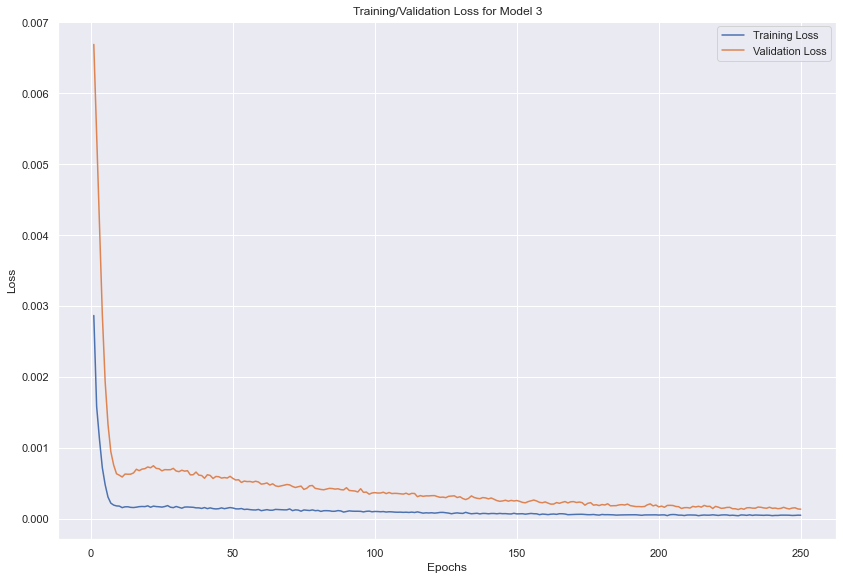

In [170]:
train_loss4, val_loss4 = history_4.history['loss'], history_3.history['val_loss']
epoch_range = range(1,epochs+1)

fig_perf4 = plt.figure(figsize = (12,8))
axis_perf4 = fig_perf4.add_axes([0.1,0.1,0.9,0.9])

axis_perf4.set_ylabel('Loss')
axis_perf4.set_xlabel('Epochs')
axis_perf4.set_title('Training/Validation Loss for Model 3')
axis_perf4.plot(epoch_range, train_loss4, label='Training Loss')
axis_perf4.plot(epoch_range, val_loss4, label='Validation Loss')
axis_perf4.legend(loc=0)

In [171]:
# prediction for model 3

predictions_4 = model4.predict(x_test)
eth_predictions_4 = min_max_scaler.inverse_transform(predictions_4)
predictions4_df = pd.DataFrame(eth_predictions_4, columns = ['Predicted Close Price'])

predictions4_df

,Predicted Close Price
0,1462.723267
1,1580.029663
2,1521.158447
3,1451.826538
4,1589.794922
...,...
384,2283.141113
385,2303.705566
386,2490.108643
387,2484.261475


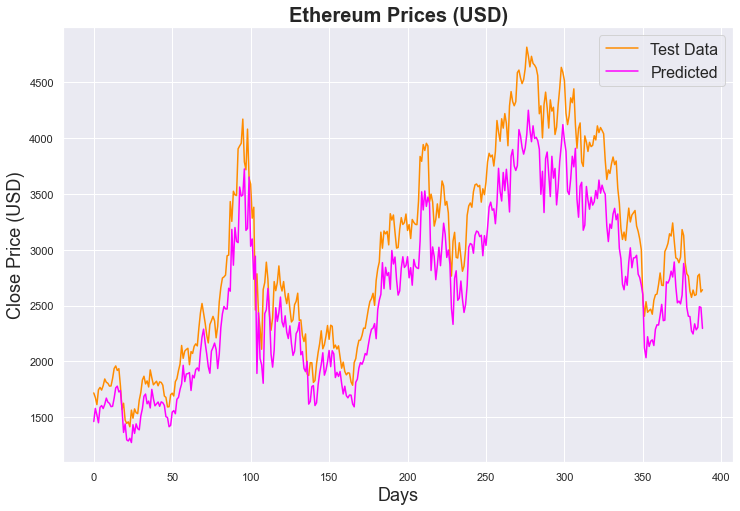

In [172]:
# plot on seaborn
plt.figure(figsize=(12,8))
sns.set_theme(style='darkgrid')
eth_axis4 = sns.lineplot(x=original_price.index, y=original_price['Close Price'], label='Test Data', color='darkorange')
eth_axis4 = sns.lineplot(x=predictions4_df.index, y=predictions4_df['Predicted Close Price'], label='Predicted', color='fuchsia')
eth_axis4.set_title('Ethereum Prices (USD)', fontsize=20, fontweight='bold')
eth_axis4.set_xlabel('Days', fontsize=18)
eth_axis4.set_ylabel('Close Price (USD)', fontsize=18)
eth_axis4.legend(loc=0, fontsize=16)

In [180]:
model_4_score = r2_score(original_price['Close Price'], eth_predictions_4)
print(f'We have an R2 Score of {model_4_score} for Model 4.')

We have an R2 Score of 0.78290646537881 for Model 4.
